_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>Aakarsh Nair, Andreas Kotzur, Ahmed Eldably</span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? Chat GPT 4o, Google Gemini  - Task Tracking, Template Code, Background Knowledge, Plotting </span>

# Coding Lab 6

In this exercise we are going to fit a latent variable model (Poisson GPFA) to both toy data and real data from monkey primary visual cortex. For details, see [Ecker et al. 2014](https://www.cell.com/neuron/pdf/S0896-6273(14)00104-4.pdf).

## Preliminaries

### 1. Code 

The toolbox we are going to use contains an implementation of the EM algorithm to fit the poisson-gpfa. 

Assuming you `git clone https://github.com/berenslab/poisson-gpfa` to the parent directory and have the following directory structure:


```
├── data/
│   └── nds_cl_6_data.mat
├── poisson-gpfa/
├── notebooks
│   └── CodingLab6.ipynb
├── matplotlib_style.txt
├── requirements.txt
```

then you can import the related functions via:

```
import sys
sys.path.append('../poisson-gpfa/')
sys.path.append('../poisson-gpfa/funs')

import funs.util as util
import funs.engine as engine
```

Change the paths if you have a different directory structure. For the details of the algorithm, please refer to the thesis `hooram_thesis.pdf` from ILIAS.

### 2. Data

Download the data file ```nds_cl_6_data.mat``` from ILIAS and save it in a ```data/``` folder.

In [23]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


# style
import seaborn as sns

sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# poisson-gpfa
import sys

sys.path.append("../poisson-gpfa/")
sys.path.append("../poisson-gpfa/funs")

import funs.util as util
import funs.engine as engine

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2025-06-01 13:29:25CEST

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.21.0

sklearn: 1.3.2

matplotlib: 3.8.0
seaborn   : 0.13.0
numpy     : 1.26.2
scipy     : 1.11.4
sys       : 3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:35:25) [Clang 16.0.6 ]

Watermark: 2.5.0



In [24]:
plt.style.use("../matplotlib_style.txt")

## Task 1. Generate some toy data to test the poisson-GPFA code

We start by verifying our code on toy data. The cell below contains code to generate data for 30 neurons, 100 trials (1000 ms each) and 50ms bin size. The neurons' firing rate $\lambda_k$ is assumed to be a constant $d_k$ modulated by a one-dimensional latent state $x$, which is drawn from a Gaussian process:

$\lambda_k = \exp(c_kx + d_k)$

Each neuron's weight $c_k$ is drawn randomly from a normal distribution and spike counts are sampled form a Poisson distribution with rate $\lambda_k$.

Your task is to fit a Poisson GPFA model with one latent variable to this data (see `engine.PPGPFAfit`).

Hint: You can use `util.dataset?`, `engine.PPGPFAfit?` or `util.initializeParams?` to find out more about the provided package.

*Grading: 3 pts*

In [25]:
# ---------------------------------
# simulate a training set (0.5 pts)
# ---------------------------------

# Initialize random number generator
np.random.seed(123)

# Specify dataset & fitting parameters

xdim = 1  # number of latent dimensions
ydim = 30  # number of neurons
numTrials = 100  # number of trials
trialDur = 1000  # trial duration (ms)
binSize = 50  # bin size (ms)
dOffset = 1  # controls baseline firing rate

# Sample from the model (make a toy dataset)
training_set = util.dataset(
    seed=np.random.randint(1e6),
    xdim=xdim,
    ydim=ydim,
    numTrials=numTrials,
    trialDur=trialDur,
    binSize=binSize,
    dOffset=dOffset,
    fixTau=False,  # sampling its own GP timescale
    drawSameX=True,  # same latent x across all neurons
)

training_set

+------------- Simulated Dataset Options -------------+
                                                    1 | Dimensionality of Latent State
                                                   30 | Dimensionality of Observed State (# neurons)
                                                 1000 | Duration of trials (ms):
                                                   50 | Size of bins (ms):
                                                  100 | Number of Trials
+-----------------------------------------------------+
Sampling trial 100 ...
Average firing rate per neuron in this dataset: 22.437 Hz.


### Fit the model

In [26]:
# -----------------------
# fit the model (0.5 pts)
# -----------------------


# Set latent dimensionality
xdim = 1

# Initialize parameters via Poisson‐PCA
init_params = util.initializeParams(
    xdim, training_set.ydim, training_set  # pass the dataset so it uses Poisson‐PCA
)

# Run EM to fit the 1‐D Poisson‐GPFA model in Batch mode
fitToy = engine.PPGPFAfit(
    experiment=training_set,
    initParams=init_params,
    xdim=xdim,
    inferenceMethod="laplace",
    maxEMiter=50,  # maximum EM iterations
    verbose=False,  # hide progress
    EMmode="Batch",  # use batch EM over all trials
)

# Inspect the fitted model object
fitToy

Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    1 | Dimensionality of Latent State
                                                   30 | Dimensionality of Observed State (# neurons)
                                                Batch | EM mode:
                                                   50 | Max EM iterations:
                                              laplace | Inference Method
+-----------------------------------------------------+
Iteration:  50 of  50, nPLL: = -449.2982
This dataset is a simulated dataset.
Processing performance against ground truth parameters...


In [27]:
# some useful functions
def allTrialsState(fit: engine.PPGPFAfit, p) -> np.ndarray:
    """Reshape the latent signal and the spike counts"""
    x = np.zeros([p, 0])
    for i in range(len(fit.infRes["post_mean"])):
        x = np.concatenate((x, fit.infRes["post_mean"][i]), axis=1)
    return x


def allTrialsX(training_set: util.dataset) -> np.ndarray:
    """Reshape the ground truth
    latent signal and the spike counts"""
    x_gt = np.array([])
    for i in range(len(training_set.data)):
        x_gt = np.concatenate((x_gt, training_set.data[i]["X"][0]), axis=0)
    return x_gt

### Plot the ground truth vs. inferred model
Verify your fit by plotting both ground truth and inferred parameters for:
1. weights C
2. biases d
3. latent state x 

Note that the sign of fitted latent state and its weights are ambiguous (you can flip both without changing the model). Make sure you correct the sign for the plot if it does not match the ground truth.

In [28]:
# All trials latent state vector
x_est = allTrialsState(fitToy, 1)
x_true = allTrialsX(training_set)

/var/folders/76/g6ys7mkj75zg7zyn8m093rk40000gn/T/ipykernel_62765/3961037687.py:76: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


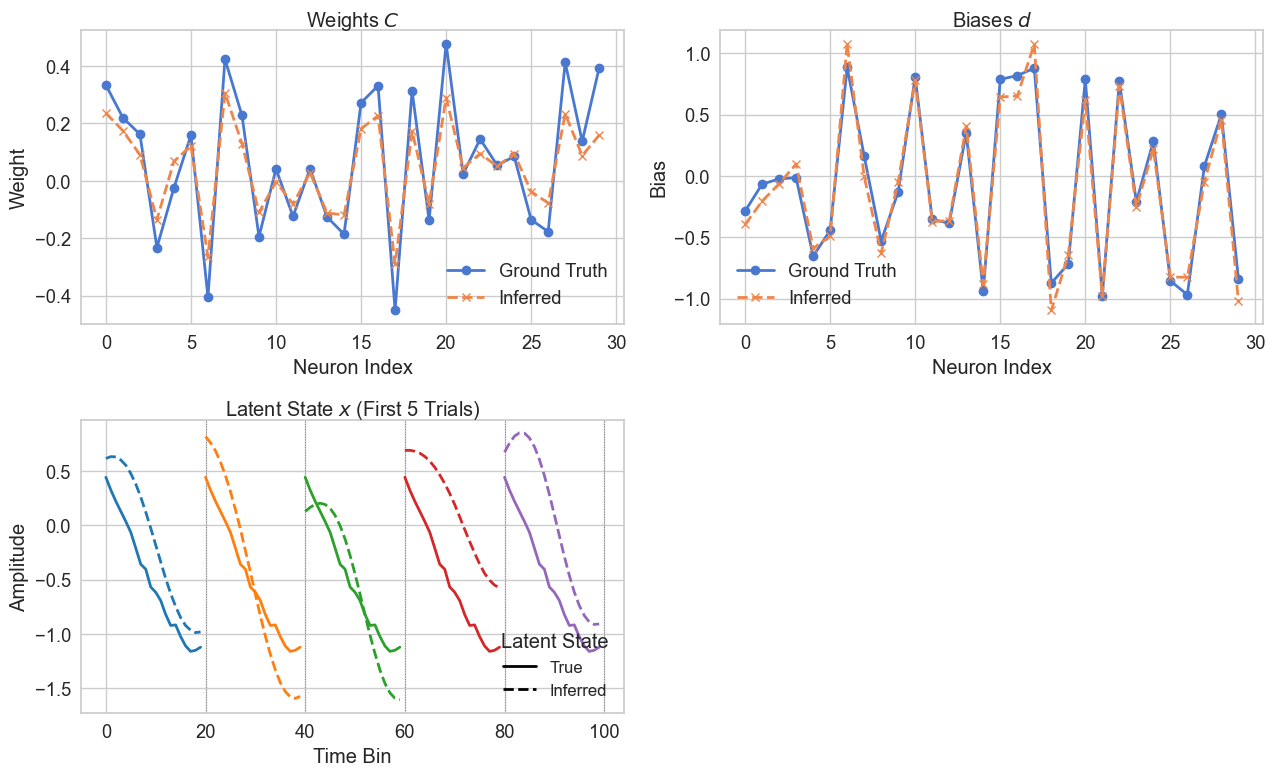

In [29]:
# ------------------------------------------------------
# Plot ground truth vs. inferred model
# Plot the weights `C`, biases `d` and latent states (2 pts)
# ------------------------------------------------------

sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Retrieve true and estimated parameters
C_true = training_set.params["C"][:, 0]
d_true = training_set.params["d"]
C_est = fitToy.optimParams["C"][:, 0]
d_est = fitToy.optimParams["d"]

# Align sign of C_est and x_est to x_true for a fair comparison
corr_sign = np.sign(np.corrcoef(x_true, x_est.flatten())[0, 1])
if corr_sign < 0:
    C_est *= -1
    x_est *= -1

# Create mosaic figure
fig, ax = plt.subplot_mosaic([["C", "d"], ["latent", "."]], figsize=(13, 8))

neurons = np.arange(len(C_true))

# Plot weights C
ax["C"].plot(neurons, C_true, marker="o", label="Ground Truth", linewidth=2)
ax["C"].plot(neurons, C_est, "--", marker="x", label="Inferred", linewidth=2)
ax["C"].set_title("Weights $C$")
ax["C"].set_xlabel("Neuron Index")
ax["C"].set_ylabel("Weight")
ax["C"].legend()

# Plot biases d
ax["d"].plot(neurons, d_true, marker="o", label="Ground Truth", linewidth=2)
ax["d"].plot(neurons, d_est, "--", marker="x", label="Inferred", linewidth=2)
ax["d"].set_title("Biases $d$")
ax["d"].set_xlabel("Neuron Index")
ax["d"].set_ylabel("Bias")
ax["d"].legend()

# Plot latent state for a subset of trials (first 5)
T = training_set.T
trials_to_plot = min(5, training_set.numTrials)
colors = sns.color_palette("tab10", trials_to_plot)
for tr in range(trials_to_plot):
    start = tr * T
    end = (tr + 1) * T
    ax["latent"].plot(
        np.arange(start, end),
        x_true[start:end],
        color=colors[tr],
        linewidth=2,
        label=f"Trial {tr+1} True" if tr == 0 else None,
    )
    ax["latent"].plot(
        np.arange(start, end),
        x_est.flatten()[start:end],
        "--",
        color=colors[tr],
        linewidth=2,
        label=f"Trial {tr+1} Inferred" if tr == 0 else None,
    )
    ax["latent"].axvline(end, color="gray", linestyle=":", linewidth=0.7)

# Clean legend: only solid for "True", dashed for "Inferred"
custom_lines = [
    Line2D([0], [0], color="black", lw=2, label="True"),
    Line2D([0], [0], color="black", lw=2, linestyle="--", label="Inferred"),
]
ax["latent"].legend(
    handles=custom_lines, title="Latent State", fontsize="small", loc="best"
)
ax["latent"].set_title("Latent State $x$ (First 5 Trials)")
ax["latent"].set_xlabel("Time Bin")
ax["latent"].set_ylabel("Amplitude")
plt.tight_layout();

## Task 2: Fit GPFA model to real data. 

We now fit the model to real data and cross-validate over the dimensionality of the latent variable.

*Grading: 4 pts*



### Load data

The cell below implements loading the data and encapsulates it into a class that matches the interface of the Poisson GPFA engine. You don't need to do anything here.

In [7]:
class EckerDataset:
    """Loosy class"""

    def __init__(
        self,
        path: str,
        subject_id: int = 0,
        ydim: int = 55,
        trialDur: int = 2000,
        binSize: int = 100,
        numTrials: int = 100,
        ydimData: bool = False,
        numTrData: bool = True,
    ):
        # T = binSize #int(trialDur/binSize)
        T = int(trialDur / binSize)
        matdat = sio.loadmat(path)
        self.matdat = matdat
        data = []
        trial_durs = []
        for trial_id in range(numTrials):
            trial_time = matdat["spikeTimes"][:, trial_id][0]
            trial_big_time = np.min(trial_time)
            trial_end_time = np.max(trial_time)
            trial_durs.append(trial_end_time - trial_big_time)
        for trial_id in range(numTrials):
            Y = []
            spike_time = []
            data.append(
                {
                    "Y": matdat["spikeCounts"][:, :, trial_id],
                    "spike_time": matdat["spikeTimes"][:, trial_id],
                }
            )
        self.T = T
        self.trial_durs = trial_durs
        self.data = data
        self.trialDur = trialDur
        self.binSize = binSize
        self.numTrials = numTrials
        self.ydim = ydim
        util.dataset.getMeanAndVariance(self)
        util.dataset.getAvgFiringRate(self)
        util.dataset.getAllRaster(self)

In [8]:
path = "../data/nds_cl_6_data.mat"
data = EckerDataset(path)

### Fit Poisson GPFA models and perform model comparison

Split the data into 80 trials used for training and 20 trials held out for performing model comparison. On the training set, fit models using one to five latent variables. Compute the performance of each model on the held-out test set.

Hint: You can use the `crossValidation` function in the Poisson GPFA package.

Optional: The `crossValidation` function computes the sum of the squared errors (SSE) on the test set, which is not ideal. The predictive log-likelihood under the Poisson model would be a better measure, which you are welcome to compute instead.

### Derivation for log‐likelihood

_You can add your calculations in_ $\LaTeX$ _here_.

$p_\lambda(x_t) = \ldots$

$L(\lambda_k; x_1, \ldots, x_N) = \ldots$ 

$\log(L) = \ell(\lambda_k; x_1, \ldots, x_N) = \ldots$



We assume that for neuron $k$, at each time‐bin $t$, the spike count $y_t$ is Poisson with rate
$$
\lambda_k(x_t)
\;=\;
\exp\bigl(c_k\,x_t + d_k\bigr).
$$

Hence the single‐bin mass function is
$$
p_{\lambda_k}(y_t \mid x_t)
=
\frac{\lambda_k(x_t)^{y_t}}{y_t!}\,\exp\bigl(-\lambda_k(x_t)\bigr)
=
\frac{\bigl[e^{\,c_k x_t + d_k}\bigr]^{y_t}}{y_t!}\,\exp\bigl(-e^{\,c_k x_t + d_k}\bigr).
$$

The likelihood over $N$ bins is
$$
L\bigl(\lambda_k;\,x_{1:N},\,y_{1:N}\bigr)
=
\prod_{t=1}^N p_{\lambda_k}(y_t \mid x_t).
$$

Taking the log gives
$$
\log L
=
\ell\bigl(\lambda_k; x_{1:N}, y_{1:N}\bigr)
=
\sum_{t=1}^N
\Bigl[
y_t\,\ln\lambda_k(x_t)
\;-\;
\lambda_k(x_t)
\;-\;
\ln\bigl(y_t!\bigr)
\Bigr]
=
\sum_{t=1}^N
\Bigl[
y_t\,(c_k\,x_t + d_k)
\;-\;
e^{\,c_k x_t + d_k}
\;-\;
\ln\bigl(y_t!\bigr)
\Bigr].
$$


In [9]:
# ------------------------------
# Perfom cross validation (1 pt)
# ------------------------------

# Set random seed for reproducibility
np.random.seed(123)

# Run cross validation using the built-in class
cv = util.crossValidation(
    experiment=data,
    numTrainingTrials=80,
    numTestTrials=20,
    maxXdim=5,  # tries xdim = 1,2,3,4,5
    maxEMiter=50,
    inferenceMethod="laplace",
    learningMethod="batch",
)

cv

Assessing optimal latent dimensionality will take a long time.
Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    1 | Dimensionality of Latent State
                                                   55 | Dimensionality of Observed State (# neurons)
                                                Batch | EM mode:
                                                   50 | Max EM iterations:
                                              laplace | Inference Method
+-----------------------------------------------------+
Iteration:  50 of  50, nPLL: = -388.9303Performing leave-one-out cross validation...
Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    2 | Dimensionality of Latent State
                                                   55 | Dimensionality of Observed State (# neurons)
         

### Plot the test error

Make a plot of the test error for the five different models. As a baseline, please also include the test error of a model without a latent variable. This is essentially the SSE of a constant rate model (or Poisson likelihood if you did the optional part above). Note: We assume a constant firing rate across trials, but not necessarily across time.

Baseline error (SSE): 65212.57


/var/folders/76/g6ys7mkj75zg7zyn8m093rk40000gn/T/ipykernel_62765/2322421609.py:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


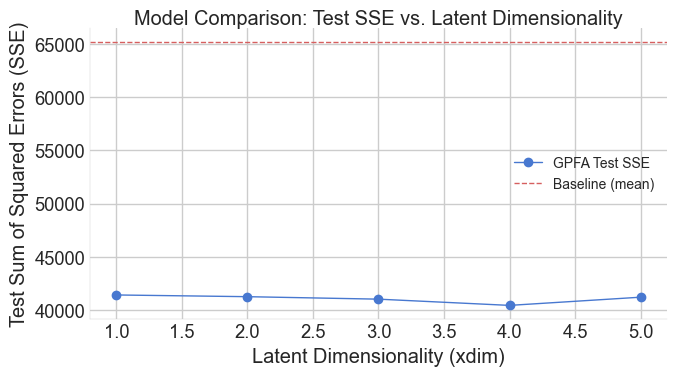

In [11]:
# --------------------------------------------------------------------------------
# Compute and plot the test errors for the different latent variable models (1 pt)
# --------------------------------------------------------------------------------

# Split the dataset for baseline error calculation
train_set, test_set = util.splitTrainingTestDataset(
    data, numTrainingTrials=80, numTestTrials=20
)

# Compute baseline error (predict mean from training set)
mean_train = np.zeros_like(test_set.data[0]["Y"])
for trial in train_set.data:
    mean_train += trial["Y"]
mean_train = mean_train / len(train_set.data)

baseline_error = 0
for trial in test_set.data:
    baseline_error += np.sum((trial["Y"] - mean_train) ** 2)

print(f"Baseline error (SSE): {baseline_error:.2f}")

# Plot test SSE for each xdim vs. baseline
plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, cv.maxXdim + 1), cv.errs, marker="o", label="GPFA Test SSE")
plt.axhline(y=baseline_error, color="r", linestyle="--", label="Baseline (mean)")
plt.xlabel("Latent Dimensionality (xdim)")
plt.ylabel("Test Sum of Squared Errors (SSE)")
plt.title("Model Comparison: Test SSE vs. Latent Dimensionality")
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/76/g6ys7mkj75zg7zyn8m093rk40000gn/T/ipykernel_62765/433412798.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


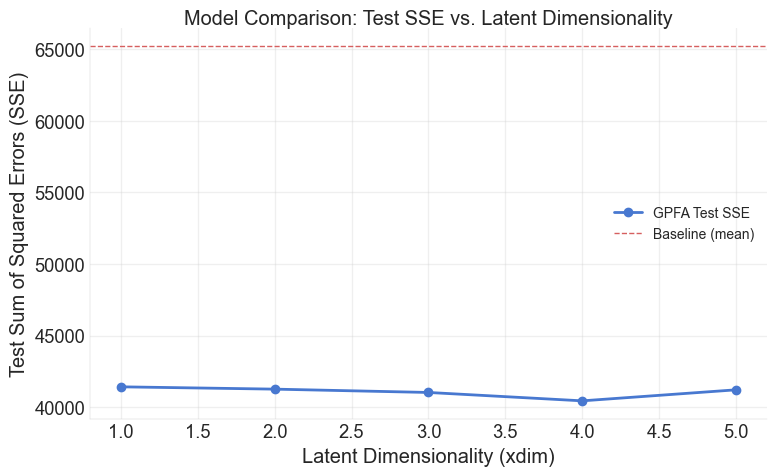

In [12]:
# -------------------------------------------------------------------------
# Compute and plot the test errors for the different latent variable models
# and answer the questions below (1+1 pts)
# -------------------------------------------------------------------------

# Your plot here
fig, ax = plt.subplots(figsize=(8, 5))

# Plot GPFA model test SSEs for xdim = 1 to 5
ax.plot(
    np.arange(1, cv.maxXdim + 1),
    cv.errs,
    marker="o",
    label="GPFA Test SSE",
    linewidth=2,
)

# Plot baseline error as horizontal dashed line
ax.axhline(baseline_error, color="r", linestyle="--", label="Baseline (mean)")

ax.set_xlabel("Latent Dimensionality (xdim)")
ax.set_ylabel("Test Sum of Squared Errors (SSE)")
ax.set_title("Model Comparison: Test SSE vs. Latent Dimensionality")
ax.legend()
ax.grid(True, which="both", alpha=0.3)
plt.tight_layout();

### Questions

Is the baseline error (0 latents) about what you expect in relation to the other models? Why or why not?

Yes. The baseline SSE (around 65 000) is much higher than the SSE of any GPFA model (which are all in the low 40 000’s). A constant‐rate model (0 latents) simply predicts each held‐out trial by the per‐bin mean computed from the training set, so it cannot capture any coordinated, time‐varying fluctuations across neurons or trials. As soon as we introduce a shared latent dimension (e.g. xdim = 1), the SSE drops dramatically (by over 20 000), because that single latent can explain much of the trial‐by‐trial variability. In short, the very large baseline SSE confirms that latent structure is essential for modeling these neural responses, so this result is exactly what we expect.

Can you identify a "best model". If so, which is it and what does this say about the structure of the latent state?

Yes. Among the GPFA fits with latent dimensionalities from 1 to 5, the lowest held‐out SSE occurs at **xdim = 4** (approximately 40 000–41 000, depending on the random split). Models with fewer than four latents underfit—the SSE decreases steadily from xdim = 1 (~ 41 500) to xdim = 3 (~41 100) and then drops most sharply between xdim = 3 and xdim = 4 (to ~ 40 500). Adding a fifth latent (xdim = 5) causes SSE to rise again (to ~41 200), indicating overfitting. Therefore, a 4‐dimensional latent space best captures the shared structure in this V1 population. This suggests there are about four dominant hidden degrees of freedom driving the trial‐to‐trial firing‐rate fluctuations across these 55 neurons.



## Task 3. Visualization: population rasters and latent state.
Use the model with a single latent state. 

Create a raster plot where you show for each trial the spikes of all neurons as well as the trajectory of the latent state `x` (take care of the correct time axis). Sort the neurons by their weights `c_k`. Plot only the first 20 trials.

*Grading: 2 pts*

Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    1 | Dimensionality of Latent State
                                                   55 | Dimensionality of Observed State (# neurons)
                                                Batch | EM mode:
                                                   50 | Max EM iterations:
                                              laplace | Inference Method
+-----------------------------------------------------+
Iteration:  50 of  50, nPLL: = -380.7547

/var/folders/76/g6ys7mkj75zg7zyn8m093rk40000gn/T/ipykernel_62765/904568448.py:99: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


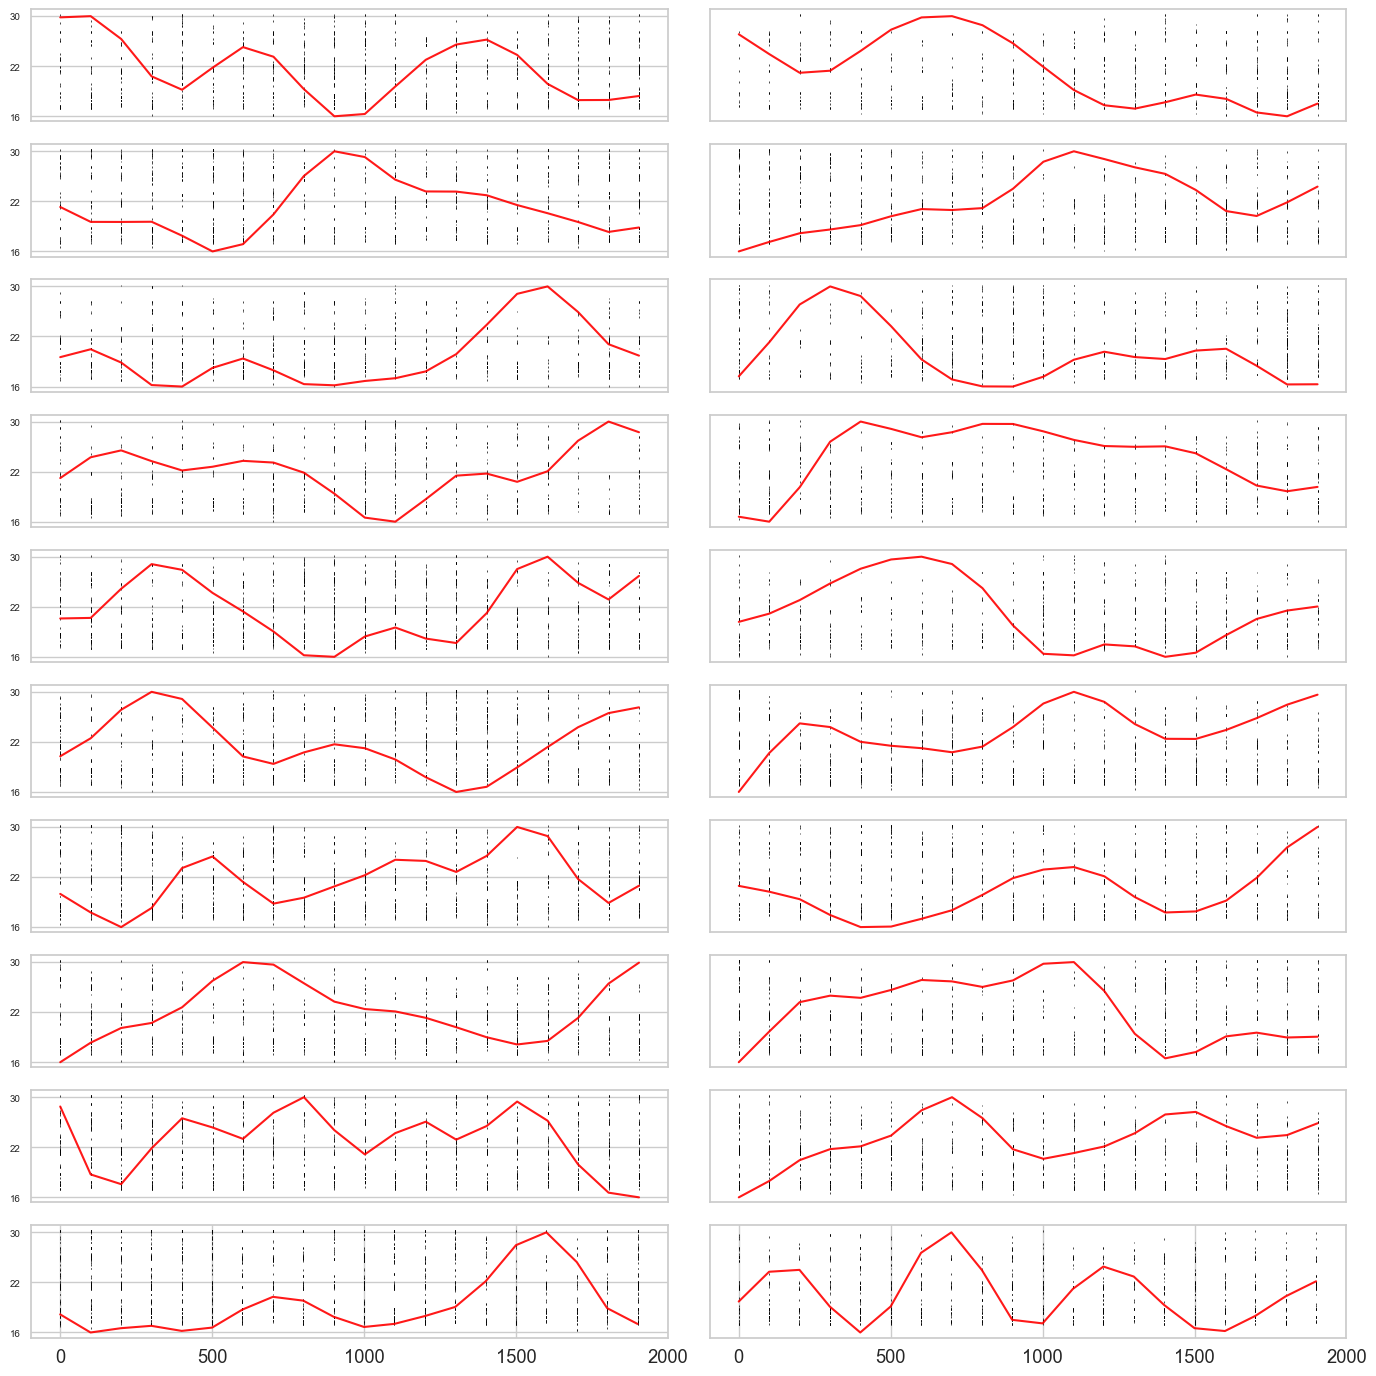

In [42]:
from numpy import matlib

# Fit Poisson‐GPFA model with xdim=1 to the FULL dataset
xdim = 1
initParams = util.initializeParams(xdim, data.ydim, data)
fit = engine.PPGPFAfit(
    experiment=data,
    initParams=initParams,
    inferenceMethod="laplace",
    EMmode="Batch",
    maxEMiter=50,
)

# Extract model weights and sort neuron indices by their C weight (descending)
C = fit.optimParams["C"].flatten()  # shape (ydim,)
neuron_order = np.argsort(C)[::-1]  # neurons sorted from largest C to smallest

# Your plot here
fig, axs = plt.subplots(10, 2, figsize=(14, 14))

# Not used
# ts = np.linspace(0, 2000, 100)
# xa = 0.15
# xs = 0.7 * xa * np.sin(ts / 1000 * 3.4 * 2 * np.pi) + xa

# Precompute raster parameters
ydim = data.ydim
T = data.T
bin_size = data.binSize

with sns.axes_style("ticks"):
    for ntrial, ax in enumerate(axs.flat):
        # If beyond trial 19, turn off the extra subplot
        if ntrial >= 20:
            ax.axis("off")
            continue

        x = range(50, 2000, 100)  # assume binsize of 100ms (placeholder)

        # --------------------------------------------------------
        # plot the raster for each neuron and latent state (2 pts)
        # --------------------------------------------------------

        # hint: can be plotted on top of the corresponding raster

        # sort neurons by weight
        spike_counts = data.data[ntrial]["Y"][neuron_order, :]  # (ydim × T)
        for neuron_idx in range(ydim):
            bins_with_spikes = np.where(spike_counts[neuron_idx, :] > 0)[0]
            for t_bin in bins_with_spikes:
                count = int(spike_counts[neuron_idx, t_bin])
                ax.vlines(
                    x=[t_bin * bin_size] * count,
                    ymin=neuron_idx,
                    ymax=neuron_idx + 1,
                    color="black",
                    linewidth=0.5,
                    alpha=1.0,
                    zorder=1,  # draw rasters first
                )

        # Overlay latent state (posterior mean) for this trial
        x_latent = fit.infRes["post_mean"][ntrial].flatten()  # length T
        x_min, x_max = x_latent.min(), x_latent.max()
        if x_max > x_min:
            x_scaled = (x_latent - x_min) / (x_max - x_min)
        else:
            x_scaled = np.zeros_like(x_latent)
        x_scaled = x_scaled * (ydim - 1)  # rescale to [0, ydim-1]

        ax.plot(
            np.arange(T) * bin_size,  # time axis in ms
            x_scaled,
            color="red",
            linewidth=1.5,
            alpha=0.9,
            solid_capstyle="round",
            label="Latent state" if ntrial == 0 else None,
            zorder=2,  # draw latent on top of rasters
        )
        # Axes ticks logic
        # only on the bottom row (trials 18 and 19)
        if ntrial in (18, 19):
            ax.set_xticks(np.arange(0, bin_size * T + 1, 500))
            ax.set_xticklabels([str(x) for x in np.arange(0, bin_size * T + 1, 500)])
        else:
            ax.set_xticks([])

        # Y‐ticks: only on the left‐most column (i.e. when ntrial%2 == 0)
        if ntrial % 2 == 0:
            # Pick a few representative neuron indices: top (0), mid (ydim/2), bottom (ydim-1)
            tick_positions = [0, ydim // 2, ydim - 1]
            tick_labels = [str(neuron_order[i] + 1) for i in tick_positions]
            ax.set_yticks(tick_positions)
            ax.set_yticklabels(tick_labels, fontsize=7)
        else:
            ax.set_yticks([])

plt.tight_layout()

## Task 4. Visualization of covariance matrix.

Plot (a) the covariance matrix of the observed data as well as its approximation using (b) one and (c) five latent variable(s). Use the analytical solution for the covariance matrix of the approximation*. Note that the solution is essentially the mean and covariance of the [log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution).

$$
\mu \;=\; \exp\Bigl(\tfrac{1}{2}\,\mathrm{diag}\bigl(C\,C^T\bigr) \;+\; d\Bigr)
$$

$$
\mathrm{Cov} \;=\;
\bigl(\mu\,\mu^T\bigr)\;\odot\;\exp\bigl(C\,C^T\bigr)
\;+\;\mu\,I\;-\;\bigl(\mu\,\mu^T\bigr)
$$

*[Krumin, M., and Shoham, S. (2009). Generation of Spike Trains with Controlled Auto- and Cross-Correlation Functions. Neural Computation 21, 1642–1664](http://www.mitpressjournals.org/doi/10.1162/neco.2009.08-08-847).

*Grading: 3 pts*


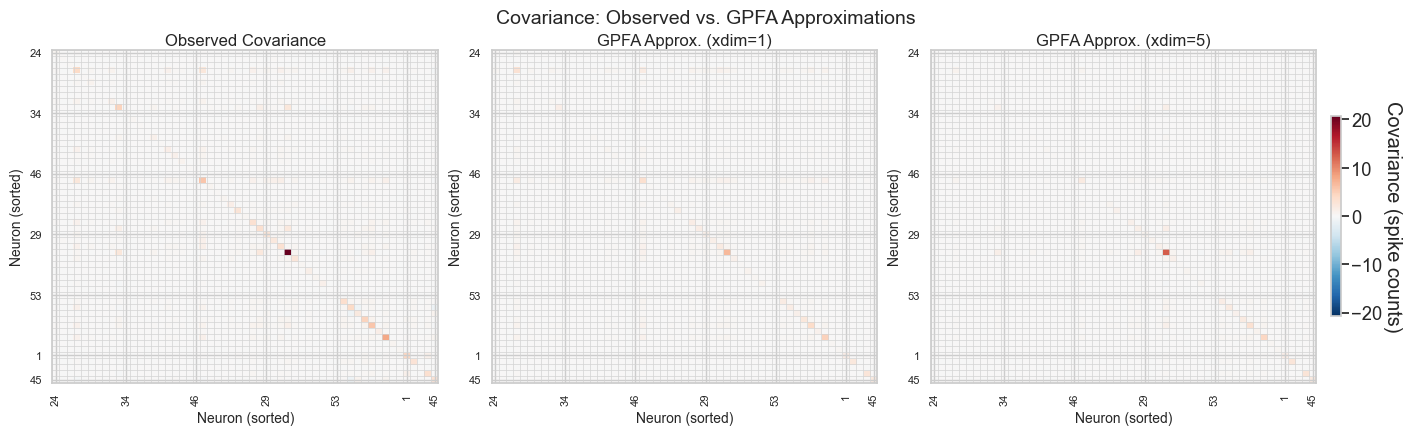

In [39]:
# --------------------------------------------------------------
# Complete the analytical solution for the covariance matrix of
# the approximation using the provide equations (2 pts)
# --------------------------------------------------------------


# Complete the analytical solution for the covariance matrix of the approximation
#    using the provided log‐normal equations.

def cov(fit: engine.PPGPFAfit) -> (np.ndarray, np.ndarray):
    C = fit.optimParams["C"]  # (ydim × xdim)
    d = fit.optimParams["d"]  # (ydim,)
    CCt = C @ C.T  # (ydim × ydim)

    # Compute mean vector μ
    mu = np.exp(0.5 * np.diag(CCt) + d)  # shape (ydim,)

    # Outer product μ_i μ_j
    mu_outer = np.outer(mu, mu)  # (ydim × ydim)

    # Exponentiated CC^T
    expCCt = np.exp(CCt)  # (ydim × ydim)

    # Analytical covariance approximation
    c = mu_outer * expCCt + np.diag(mu) - mu_outer  # (ydim × ydim)
    return c, mu


# Plot the covariance matrix of
#    (1) the observed data,
#    (2) its approximation using 1 latent variable (xdim=1), and
#    (3) its approximation using 5 latent variables (xdim=5).
#
#    Hint: Use a diverging colormap (e.g., "RdBu_r") and the same vmin/vmax for all three.

# Observed covariance
obs_cov = np.cov(data.all_raster)  # data.all_raster is (neurons × total_time_bins)

# GPFA approximations
opt_cov1, mu1 = cov(cv.fits[0])  # xdim=1 fit
opt_cov5, mu5 = cov(cv.fits[4])  # xdim=5 fit

# Sort neurons by the magnitude of their weights under xdim=5, for clarity
C5 = cv.fits[4].optimParams["C"]  # shape (neurons × 5)
neuron_norms = np.linalg.norm(C5, axis=1)  # Euclidean norm per neuron
sort_idx = np.argsort(neuron_norms)[::-1]  # descending order of norm

obs_cov_s = obs_cov[np.ix_(sort_idx, sort_idx)]
opt_cov1_s = opt_cov1[np.ix_(sort_idx, sort_idx)]
opt_cov5_s = opt_cov5[np.ix_(sort_idx, sort_idx)]

# Choose symmetric color range across all three matrices
vmax = max(np.abs(obs_cov_s).max(), np.abs(opt_cov1_s).max(), np.abs(opt_cov5_s).max())

# Set up a 1×3 figure to compare observed vs. approximations
fig, axs = plt.subplots(1, 3, figsize=(14, 4), constrained_layout=True)
cmap = "RdBu_r"  # diverging colormap

titles = ["Observed Covariance", "GPFA Approx. (xdim=1)", "GPFA Approx. (xdim=5)"]
matrices = [obs_cov_s, opt_cov1_s, opt_cov5_s]

for i, (mat, title) in enumerate(zip(matrices, titles)):
    ax = axs[i]
    im = ax.imshow(
        mat, aspect="auto", interpolation="nearest", cmap=cmap, vmin=-vmax, vmax=+vmax
    )
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Neuron (sorted)", fontsize=10)
    ax.set_ylabel("Neuron (sorted)", fontsize=10)

    # Draw light grid lines between each pixel to highlight blocks
    for y0 in range(mat.shape[0] + 1):
        ax.axhline(y=y0 - 0.5, color="lightgray", linewidth=0.5)
        ax.axvline(x=y0 - 0.5, color="lightgray", linewidth=0.5)

# Add tick labels for a few representative neurons
pick_ticks = [0, 10, 20, 30, 40, 50, 54]  # indices in sorted order
orig_ids = [str(sort_idx[k] + 1) for k in pick_ticks]  # convert to 1-indexed IDs

for ax in axs:
    ax.set_xticks(pick_ticks)
    ax.set_xticklabels(orig_ids, rotation=90, fontsize=8)
    ax.set_yticks(pick_ticks)
    ax.set_yticklabels(orig_ids, fontsize=8)

# Shared colorbar on the right
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.6, pad=0.01)
cbar.set_label("Covariance (spike counts)", rotation=270, labelpad=14)

fig.suptitle("Covariance: Observed vs. GPFA Approximations", fontsize=14, y=1.05);

### Questions

What do you see/expect to see?

In the **Observed Covariance** panel, most neuron pairs exhibit positive covariance (red hues), especially among the top‐weighted cells (upper‐left corner after sorting). There are very few negative covariances (hence almost no blue), indicating that this V1 population tends to co‐fluctuate rather than anti‐correlate.

In the **GPFA Approx. (xdim=1)** panel, a single latent captures only the largest covariance “block” (the brightest red region), but it fails to reproduce many of the smaller off‐diagonal covariances. Thus, xdim=1 oversimplifies the population structure—only the strongest co‐modulation is recovered.

In the **GPFA Approx. (xdim=5)** panel, the approximation more closely matches the observed pattern: multiple covariance “hotspots” appear in the same sorted neuron indices. Although xdim=5 still slightly underestimates some subtle covariances, it recreates most of the positive‐covariance structure (and produces few spurious negative values). In other words, increasing from 1→5 latents progressively recovers more of the true pairwise covariance, as we'd expect from a richer latent subspace.

